## Smart water flooding analytical solution
This document is mostly based on the SPE-7660 paper by Gary Pope. I first implement the simple water flooding analytical solution and then expand it to low salinity water flooding with and without ionic adsorption.

## Mathematical model
The two phase flow equation in a 1D porous medium reads
$$\frac{\partial S_w}{\partial t}+\frac{u}{\varphi}\frac{df_w}{dS_w}\frac{\partial S_w}{\partial x} = 0 $$
The dimensionless time and space are defined as
$$t_D = \frac{ut}{\varphi L}$$ and
$$x_D = \frac{x}{L}$$
The velocity of a constant saturation front is calculated by
$$V_{S_w} = (\frac{dx}{dt})_{S_w}=\frac{u}{\varphi}\frac{df_w}{dS_w}$$
The shock front is specified by
$$\frac{f_w(S_{w,shock})-f_w(S_{w,init})}{S_{w,shock}-S_{w,init}}=\left(\frac{df_w}{dS_w}\right)_{S_{w,shock}}$$
The injected water front velocity (i.e., a tracer in the injected water, or the low salinity of the injected brine) is calculated by
$$V_{c} = (\frac{dx}{dt})_{c}=\frac{u}{\varphi}\frac{f_w}{S_w}$$
an the water saturation that corresponds to the position of the salinity front is given by
$$\frac{f_w(S_{w,s})-f_w(0)}{S_{w}-0.0}=\left(\frac{df_w}{dS_w}\right)_{S_{w,shock}}$$
which is the tangent line fron the point (0,0) to the $f_w-S_w$ (fractional flow) curve.
The breakthrough time (in number of pore volume) is calculated by
$$t_{D, bt} = \left(\frac{df_w}{dS_w}\right)^{-1}_{S_{w,shock}}$$
The other useful relation is the average saturation after breakthrough, which reads
$$S_{w,av} = S_{or}+\left[(1-f_w)\left(\frac{df_w}{dS_w}\right)\right]_{x=L}, \;t_D>t_{D,bt}$$ 
The recovery factor then can be calculated based on the fact that the recovery curve is linear until the breakthrough, and after breakthrough it gradually reaches a plateau. The oil recovery factor before the breakthrough is calculated by
$$R = \frac{(1-f_w(S_{w,init}))t_D}{1-S_{w,init}}, \;t_D<t_{D,bt}$$ and after breakthrough by
$$R = \frac{S_{w,init}-S_{w,av}}{1-S_{w,init}}, \; t_D>t_{D,bt}$$
Let's try the above formulation in Julia.

## Testing the codes
The `FractionalFlow.jl` package is built to solve and visualize the analytical solutions to several injection problem in the petroleum engineering, including water flooding, low salinity water flooding with and without ionic adsorption, and solvent flooding (carbonated water, DME, etc). There are several functions that are documented in the code. Here, I show by example how to define a problem, solve it, and visualize the results.

In [102]:
include("FractionalFlow.jl")
using PyPlot
FF = FractionalFlow

FractionalFlow

## Water flooding

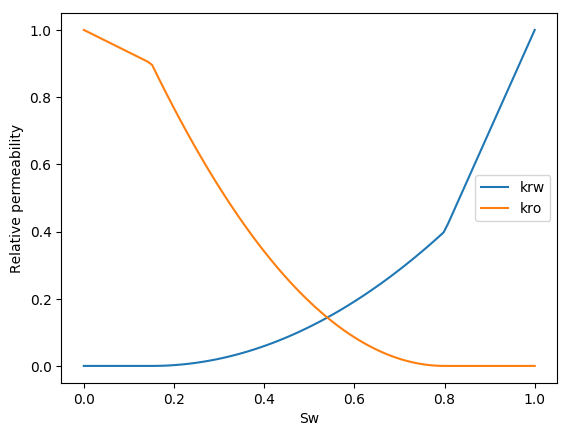

PyObject <matplotlib.legend.Legend object at 0x7f3c154f9c90>

In [103]:
# define the problem
# relative permeabilities
rel_perms = FF.oil_water_rel_perms(krw0=0.4, kro0=0.9, 
    swc=0.15, sor=0.2, nw=2.0, no = 2.0)
FF.visualize(rel_perms)

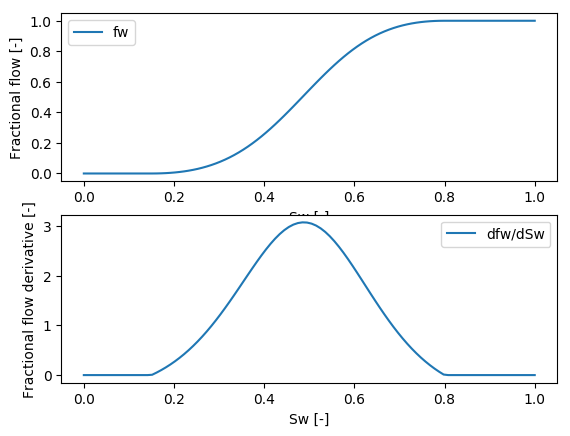

PyObject <matplotlib.legend.Legend object at 0x7f3c1543abd0>

In [104]:
# define the fluids
fluids = FF.oil_water_fluids(mu_water=1e-3, mu_oil=2e-3)

# define the fractional flow functions
fw, dfw = FF.fractional_flow_function(rel_perms, fluids)
# visualize the fractional flow
FF.visualize(rel_perms, fluids)

sw_shock = 0.608438467199255


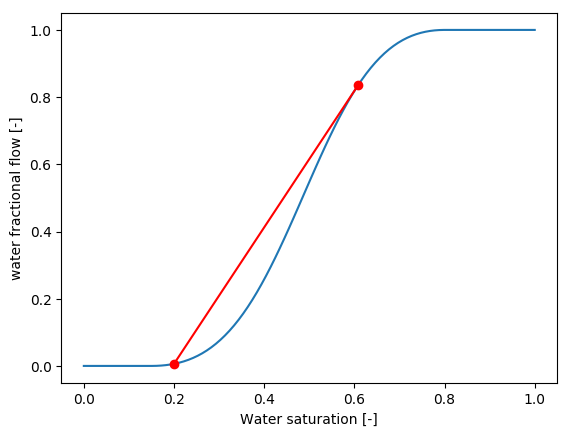

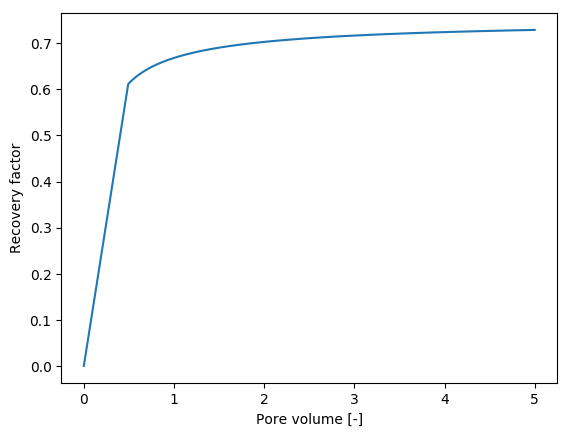

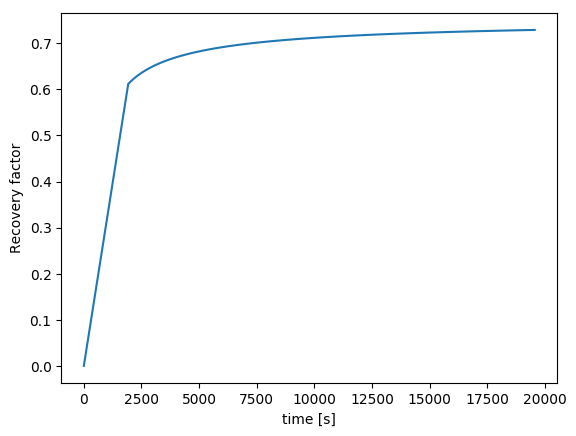

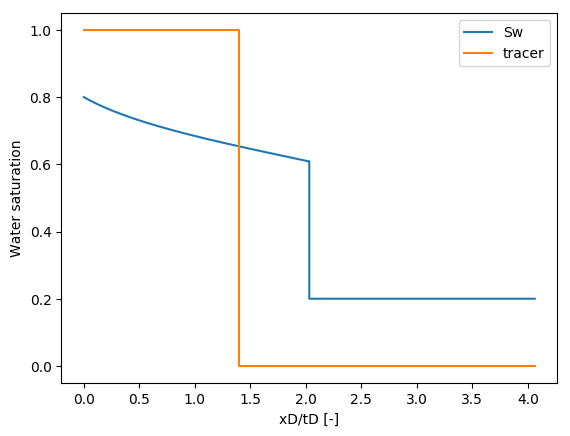

breakthrough time = 0.4922812627958595


PyObject <matplotlib.legend.Legend object at 0x7f3c152b2750>

In [105]:
core_flood = FF.core_flooding(u_inj=1.15e-5, pv_inject=5.0, 
    p_back=1e5, sw_init=0.2, sw_inj=1.0, rel_perms=rel_perms)
core_props = FF.core_properties()
wf_res = FF.water_flood(core_props, fluids, rel_perms, core_flood)
fw, dfw = FF.fractional_flow_function(rel_perms, fluids)
sw_tmp = linspace(0,1,100)
# plot(sw_tmp, fw.(sw_tmp), xlabel = "Sw", ylabel="fw", label="")
# plot!(sw_tmp, dfw.(sw_tmp))
# figure(1)
# plot(pv, R) 
# xlabel("PV injected")
# ylabel("Recovery factor") 
# title("Water flooding")
# figure(2)
# plot(xt, sw)
# xlabel("x/t [-]")
# ylabel("Water saturation [-]")
FF.visualize(wf_res)

## Low salinity water flooding - with/without adsorption

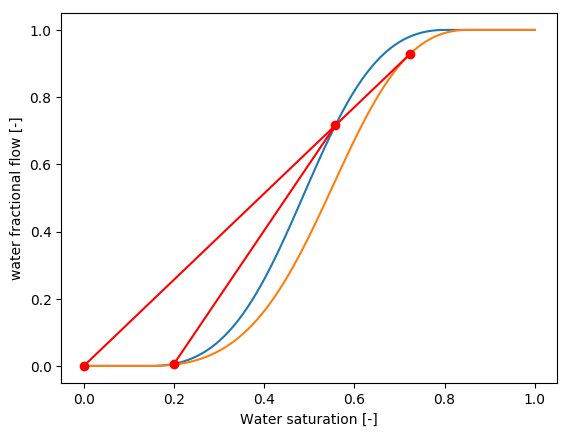

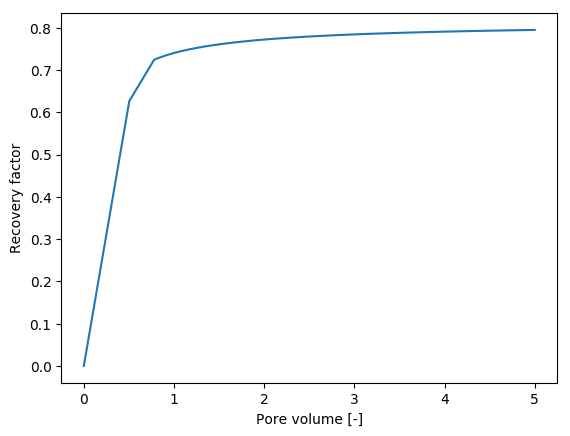

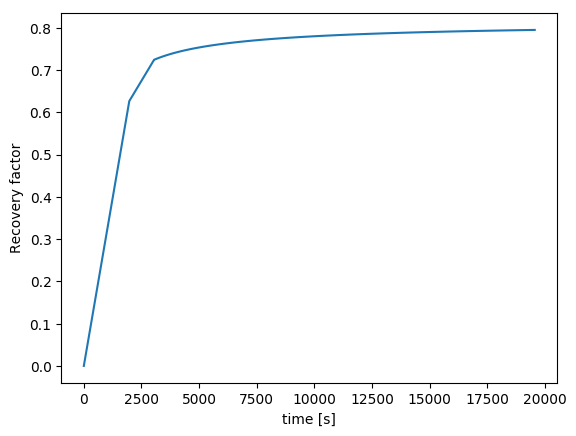

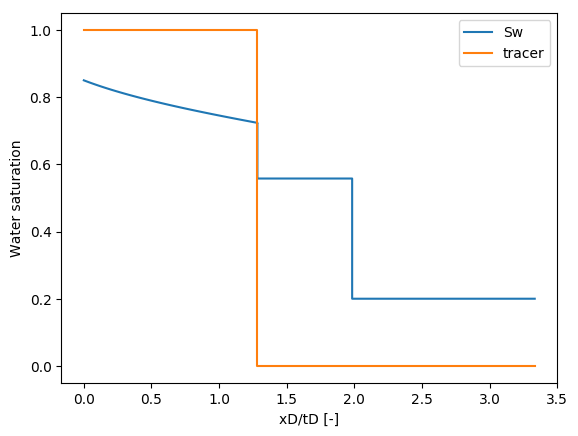

low sal sw_shock = 0.7233666450788676
low sal breakthrough time = 0.7792345274868723
high sal sw_shock = 0.5577460825529506
high sal breakthrough time = 0.5041328948599879


PyObject <matplotlib.legend.Legend object at 0x7f3c150b6b90>

In [106]:
fluids_hs = FF.oil_water_fluids(mu_water=1e-3, mu_oil=2e-3)
fluids_ls = FF.oil_water_fluids(mu_water=1e-3, mu_oil=2e-3)
rel_perms_hs = FF.oil_water_rel_perms(krw0=0.4, kro0=0.9, 
        swc=0.15, sor=0.2, nw=2.0, no = 2.0)
rel_perms_ls = FF.oil_water_rel_perms(krw0=0.3, kro0=0.95, 
        swc=0.15, sor=0.15, nw=2.0, no = 2.0)
core_flood = FF.core_flooding(u_inj=1.15e-5, pv_inject=5.0, p_back=1e5, sw_init=0.2, sw_inj=1.0, rel_perms=rel_perms_hs)
core_props = FF.core_properties()
ls_res = FF.low_sal_water_flood(core_props, fluids_ls, fluids_hs, rel_perms_hs, 
        rel_perms_ls, core_flood)
FF.visualize(ls_res)

## compare with numeric

In [107]:
t_sec, pv_num, rec_fact, xt_num, sw_num, c_old, c_out_sal = 
    FF.forced_imb_implicit_upwind(core_props, fluids_ls, fluids_hs, rel_perms_hs, 
        rel_perms_ls, core_flood)
# plot(ls_res)

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] abs(::Array{Float64,1}) at ./deprecated.jl:57
 [3] forced_imb_implicit_upwind(::FractionalFlow.CoreProperties, ::FractionalFlow.Fluids, ::FractionalFlow.Fluids, ::FractionalFlow.CoreyRelativePermeability, ::FractionalFlow.CoreyRelativePermeability, ::FractionalFlow.CoreFlooding) at /home/ehsan/projects/peteng/analytical/water_flood_fvm_upwind.jl:218
 [4] include_string(::String, ::String) at ./loading.jl:522
 [5] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/ehsan/.julia/v0.6/IJulia/src/execute_request.jl:158
 [6] (::Compat.#inner#17{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /home/ehsan/.julia/v0.6/Compat/src/Compat.jl:385
 [7] eventloop(::ZMQ.Socket) at /home/ehsan/.julia/v0.6/IJulia/src/eventloop.jl:8
 [8] (::IJulia.##14#17)() at ./task.jl:335
while loading In[107], in expression starting on line 1
Progress:  99%|█████████████████████████████████████████|  ETA: 0:00:00

([0.0, 1.30435, 2.6087, 3.91304, 5.21739, 6.52174, 7.82609, 9.13043, 10.4348, 11.7391  …  1553.48, 1554.78, 1556.09, 1557.39, 1558.7, 1560.0, 1561.3, 1562.61, 1563.91, 1565.22], [0.0, 0.000333333, 0.000666667, 0.001, 0.00133333, 0.00166667, 0.002, 0.00233333, 0.00266667, 0.003  …  0.397, 0.397333, 0.397667, 0.398, 0.398333, 0.398667, 0.399, 0.399333, 0.399667, 0.4], [0.0, 0.00041411, 0.000828221, 0.00124233, 0.00165644, 0.00207055, 0.00248466, 0.00289877, 0.00331288, 0.00372699  …  0.493206, 0.49362, 0.494034, 0.494448, 0.494862, 0.495276, 0.49569, 0.496104, 0.496518, 0.496933], [0.0, 0.0003, 0.0006, 0.0009, 0.0012, 0.0015, 0.0018, 0.0021, 0.0024, 0.0027  …  0.1473, 0.1476, 0.1479, 0.1482, 0.1485, 0.1488, 0.1491, 0.1494, 0.1497, 0.15], [1.0, 0.848014, 0.847118, 0.846274, 0.845458, 0.844661, 0.843879, 0.843107, 0.842346, 0.841593  …  0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2], JFVM.CellValue(JFVM.MeshStructure(1, [500], JFVM.CellSize{Float64}([0.0003, 0.0003, 0.0003, 0.0003, 0.00

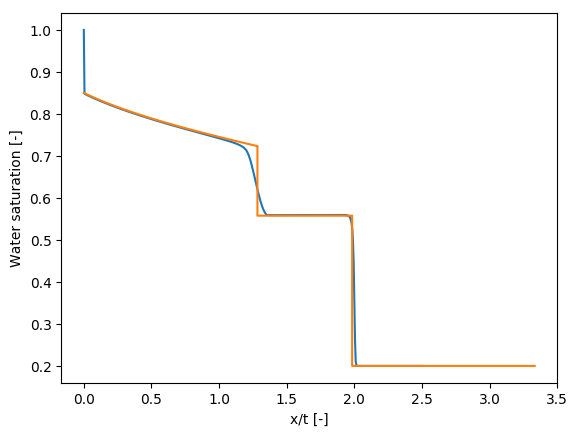

PyObject Text(24,0.5,'Water saturation [-]')

In [108]:
figure(2)
plot(xt_num/(core_props.length)/0.4, sw_num)
plot(ls_res.saturation_profile_xt[:,1], ls_res.saturation_profile_xt[:,2])
xlabel("x/t [-]")
ylabel("Water saturation [-]")

## Low salinity flooding, an exceptional case

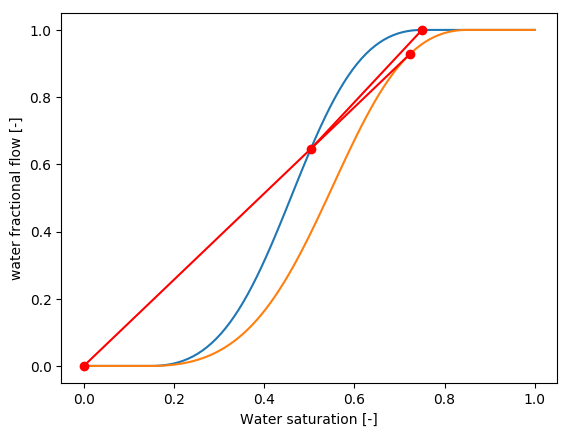

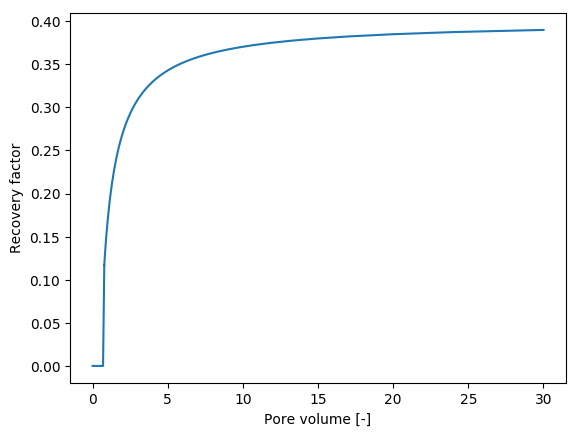

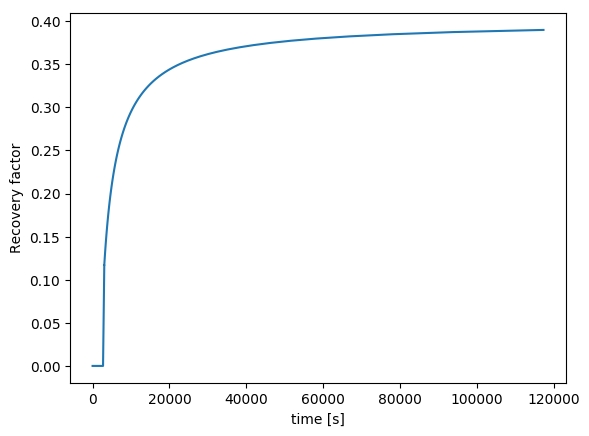

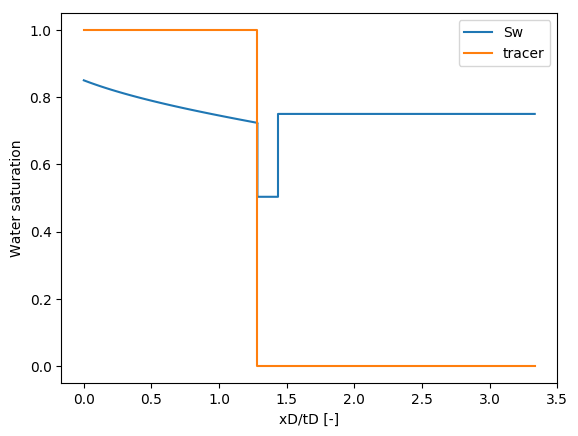

low sal sw_shock = 0.7233666450788676
low sal breakthrough time = 0.7792345274868723
high sal sw_shock = 0.5033633510803514
high sal breakthrough time = 0.6966577483203314


PyObject <matplotlib.legend.Legend object at 0x7f3c16595690>

In [109]:
sor_hs = 0.25
sw_init = 1-sor_hs
fluids_hs = FF.oil_water_fluids(mu_water=1e-3, mu_oil=2e-3)
fluids_ls = FF.oil_water_fluids(mu_water=1e-3, mu_oil=2e-3)
rel_perms_hs = FF.oil_water_rel_perms(krw0=0.4, kro0=0.9, 
        swc=0.15, sor=sor_hs, nw=2.0, no = 2.0)
rel_perms_ls = FF.oil_water_rel_perms(krw0=0.3, kro0=0.95, 
        swc=0.15, sor=0.15, nw=2.0, no = 2.0)
core_flood = FF.core_flooding(u_inj=1.15e-5, pv_inject=30.0, p_back=1e5, sw_init=sw_init, 
    sw_inj=1.0, rel_perms=rel_perms_hs)
core_props = FF.core_properties()
ls_res = FF.low_sal_water_flood(core_props, fluids_ls, fluids_hs, rel_perms_hs, 
        rel_perms_ls, core_flood)
FF.visualize(ls_res)

## Solvent injection: DME example

In [110]:
ls_res.recovery_pv

103×2 Array{Real,2}:
  0.0       0.0     
  0.696658  0.0     
  0.779235  0.116938
  0.779235  0.116938
  0.789268  0.119784
  0.799535  0.122632
  0.810043  0.125482
  0.820799  0.128335
  0.831811  0.131189
  0.843086  0.134046
  0.854634  0.136903
  0.866462  0.139763
  0.878581  0.142623
  ⋮                 
  7.71061   0.361944
  8.29923   0.364518
  8.978     0.367085
  9.76924   0.369644
 10.7033    0.372195
 11.8227    0.374739
 13.1882    0.377274
 14.8911    0.379802
 17.0736    0.382322
 19.9713    0.384833
 24.004     0.387337
 30.0       0.389832

In [111]:
Pkg.add("ProgressMeter")

INFO: Package ProgressMeter is already installed
INFO: METADATA is out-of-date — you may not have the latest version of ProgressMeter
INFO: Use `Pkg.update()` to get the latest versions of your packages
